## Imports

In [1]:
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

## definitions

In [2]:
np.random.seed(42)
NUM_FEATURE = 12
RANDOM_DATA = True

In [3]:
def get_data(red=False):
    #get red wine data  
    red_data = np.genfromtxt('../data/winequality-red.csv',delimiter=';')
    red_data = np.delete(red_data,(0),axis=0)
    red_feature = np.array([[1 for i in range(red_data.shape[0])]])
    red_y = np.array([red_data[:,11]])
    red_data = np.append(red_data[:,0:11],red_feature.T,axis=1)
    red_data = np.append(red_data,red_y.T,axis=1)
    print
    if red:
        return red_data
        #get white wine data
    white_data = np.genfromtxt('../data/winequality-white.csv',delimiter=';')
    white_data = np.delete(white_data,(0),axis=0)
    white_feature = np.array([[-1 for i in range(white_data.shape[0])]])
    white_y = np.array([white_data[:,11]])
    white_data = np.append(white_data[:,0:11],white_feature.T,axis=1)
    white_data = np.append(white_data,white_y.T,axis=1)
    #combine the 2
    data = np.append(red_data,white_data,axis=0)
    if RANDOM_DATA:
        np.random.shuffle(data)
    return data

## Data Split
split 80% training, 20% test Normalised using training data

In [4]:
def split_data(data,train_split=0.8):
    #train,test,val
    train,test = np.split(data, [int(train_split*data.shape[0])])

    train_x,train_y = np.hsplit(train,[NUM_FEATURE])
    test_x,test_y   = np.hsplit(test, [NUM_FEATURE])
    
    #remove outliers
    
    #normalise data
    for i in range(NUM_FEATURE):
        mean  = train_x[:,i].mean()
        std   = train_x[:,i].std() 

        #normalise training data
        train[:,i] = (train_x[:,i] - mean)/std
        #normalise test data  
        test[:,i] = (test_x[:,i] - mean)/std
  
    return train_x,train_y,test_x,test_y


## Loss Function Definitions
Used for working out loss and errors.

In [5]:
def square_loss(y,pred_y):
    return ((y-pred_y)**2).mean()

def mae_loss(y,pred_y):
    return (abs(y-pred_y)).mean()
  
def identity_loss(y,pred_y):
    N = len(y)
    error_sum = 0
    for i in range(N):
        if int(y[i]) != int(pred_y[i]):
            error_sum += 1
    return error_sum/N

## Cross-Validation 

In [226]:
def cross_validation(train_x,train_y,model,k=10,loss=mae_loss):
    #split into K folds
    data = np.concatenate((train_x,train_y),axis=1)
    kf = KFold(n_splits=k)
    feature_size = len(train_x[0])

    error_sum = 0
    error = [0 for i in range(k)]
    i=0
    for train,test in kf.split(data):
        train_data  = np.array(data)[train]  
        test_data   = np.array(data)[test]  
        train_x, train_y  = np.hsplit(train_data,[feature_size])
        test_x , test_y   = np.hsplit(test_data,[feature_size])
        model.fit(train_x,train_y)
        pred_y = model.predict(test_x)
        tmp = loss(test_y,pred_y)
        error_sum += tmp
        error[i] = tmp
        i+=1

    #return error_sum/k 
    return error

## Regression Models

In [7]:
def sk_lin_regr(data):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.LinearRegression() 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_lasso_regr(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Lasso(alpha) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Lasso MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_ridge_regr(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Ridge(alpha) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(train_x)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Ridge MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_elastic_regr(data,alpha=0.1, l1_ratio=0.5):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.ElasticNet(alpha, l1_ratio) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Elastic Net MAE: ",mean_absolute_error(test_y,pred_y))
    return regr


## Training Graph

In [229]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 100)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Absolute Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='neg_mean_absolute_error', train_sizes=train_sizes)
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, color="r",
             label="Training Error")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Cross-validation Error")

    plt.legend(loc="best")
    return plt

In [230]:
def plot_validation_curve(estimator,X,y, title, scoring, param_name,param_range):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=10, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Error")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [231]:
def plot_coef(model,X,y,param_name,param_range):
    coefs = []
    for val in param_range:
        if param_name=='alpha':
            model.set_params(alpha=val)
        if param_name=='l1_ratio':
            model.set_params(l1_ratio=val)
        model.fit(X, y)
        coefs.append(model.coef_)
# #############################################################################
# Display results

    ax = plt.gca()

    ax.plot(param_range, coefs[::-1])
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Ridge coefficients as a function of the regularization')
    plt.axis('tight')
    return plt

(sk) linear regression MAE:  0.5753720989544389


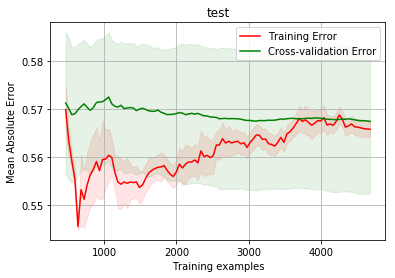

In [232]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_lin_regr(data)
plot_learning_curve(model, "test", train_x, train_y,cv=10)
plt.show()
 

(sk) linear regression Ridge MAE:  0.5724163561732108


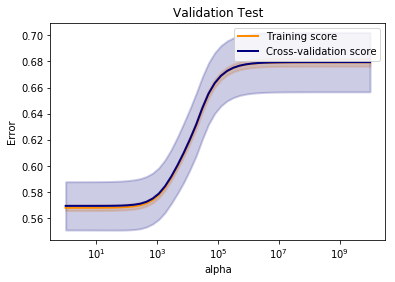

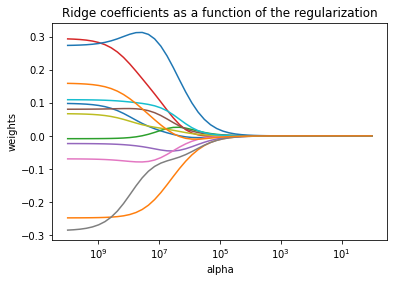

In [52]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_ridge_regr(data,0.1)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','alpha',np.logspace(0,10,50))
plt.show()
plot_coef(model, train_x,train_y,'alpha',np.logspace(0,10,50))
plt.show()

(sk) linear regression Lasso MAE:  0.586684804751893


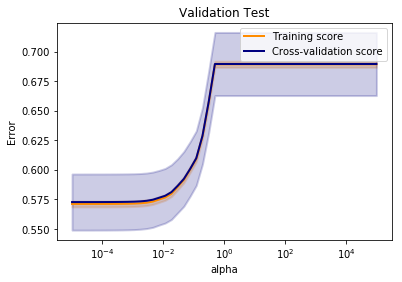

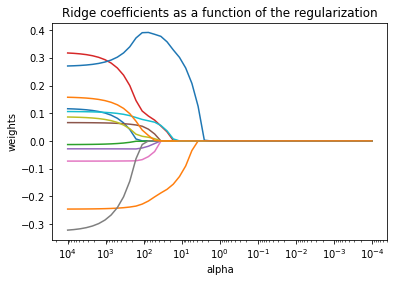

In [54]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_lasso_regr(data,0.1)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','alpha',np.logspace(-5,5,50))
plt.show()
plot_coef(model, train_x,train_y,'alpha',np.logspace(-4,4,50))
plt.show()

(sk) linear regression Elastic Net MAE:  0.5438499903006081


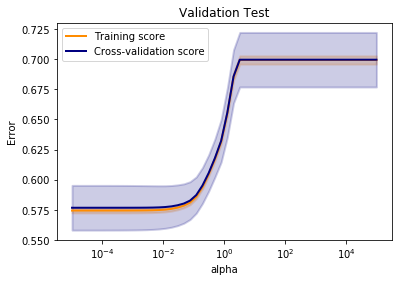

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

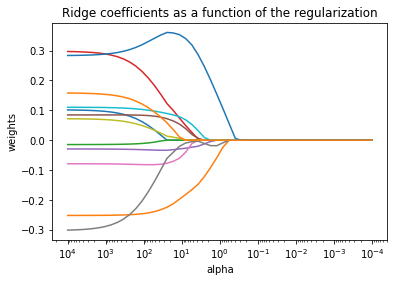

In [55]:
data = get_data(False) 
#df = pd.DataFrame(data)
#print(df)
train_x,train_y,test_x,test_y = split_data(data)
model = sk_elastic_regr(data,0.0001,0.15)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','alpha',np.logspace(-5,5,50))
plt.show()
plot_coef(model, train_x,train_y,'alpha',np.logspace(-4,4,50))

(sk) linear regression Elastic Net MAE:  0.5651757158358962


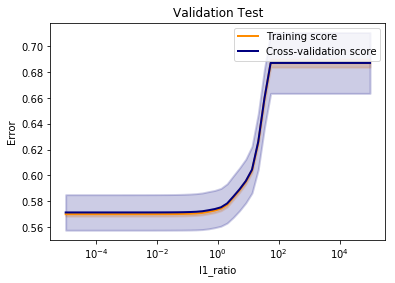

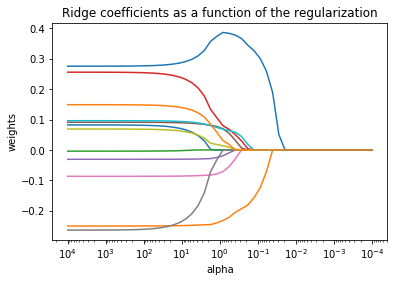

In [56]:
data = get_data(False) 
#df = pd.DataFrame(data)
#print(df)
train_x,train_y,test_x,test_y = split_data(data)
model = sk_elastic_regr(data,0.01,0.01)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','l1_ratio',np.logspace(-5,5,50))
plt.show()
plot_coef(model, train_x,train_y,'l1_ratio',np.logspace(-4,4,50))
plt.show()

In [220]:
def bitfield(n):
    return [int(digit) for digit in bin(n)[2:]] 

def search_all_features(data):
    train_x,train_y,test_x,test_y = split_data(data)
    return_list = []
    for i in range(2**12):
        tmp_train_x = train_x
        tmp_test_x  = test_x
        feature_index = bitfield(i)
        tmp = [0 for i in range(NUM_FEATURE-len(feature_index))]
        tmp.extend(feature_index)
        feature_index = tmp
        delete_elements = []
        for j in range(len(feature_index)):
            if(feature_index[j]==0):
                delete_elements.append(j)

        tmp_train_x = np.delete(tmp_train_x,delete_elements,axis=1)
        tmp_test_x  = np.delete(tmp_test_x ,delete_elements,axis=1)
        
        if tmp_train_x!=[]:
            regr = linear_model.LinearRegression() 
            #regr.fit(tmp_train_x,train_y)
            #pred_y = regr.predict(tmp_test_x)
            feature_index.append(cross_validation(tmp_train_x,train_y,regr))
            return_list.append(feature_index)
            #print("(sk) linear regression MAE: ",feature_index)    
    return return_list

In [227]:
data = get_data()
l = search_all_features(data)
for i in range(len(l)):
    std  = np.array(l[i][12]).std()
    mean = np.array(l[i][12]).mean()
    print("mean: ",mean,", std: ",std)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


mean:  0.6151451553119653 , std:  0.01739965002517613
mean:  0.6713340003043913 , std:  0.015900586205592718
mean:  0.619485500321628 , std:  0.01755202988249727
mean:  0.6085646581494232 , std:  0.016047184592585438
mean:  0.6729080706719586 , std:  0.014683462421699232
mean:  0.6214657950375707 , std:  0.018313269635364147
mean:  0.6155186420537099 , std:  0.017434891383781143
mean:  0.6868918636270329 , std:  0.015190038169191946
mean:  0.6705494474652713 , std:  0.016818246046421254
mean:  0.6201249123182413 , std:  0.01780865921027111
mean:  0.6089669120437488 , std:  0.01601753516037666
mean:  0.6560441656137599 , std:  0.013278114152717728
mean:  0.6205974310333194 , std:  0.017824636813151253
mean:  0.6109657258924244 , std:  0.016753100937479625
mean:  0.6507364031964816 , std:  0.014149947982524879
mean:  0.6504786034803896 , std:  0.01424846946227562
mean:  0.6195580840515051 , std:  0.017500903452245153
mean:  0.6056894763163004 , std:  0.015849615005666683
mean:  0.6554669

mean:  0.6060208347327025 , std:  0.016879801472332832
mean:  0.6566923540128651 , std:  0.016572740289225764
mean:  0.6558315748979539 , std:  0.016878215731590037
mean:  0.5990168034297565 , std:  0.016018985334355033
mean:  0.5977321025340885 , std:  0.015569483855019188
mean:  0.6443036079537493 , std:  0.0160014194335041
mean:  0.6372714441778412 , std:  0.019291701442236908
mean:  0.606233908149242 , std:  0.016881958140061618
mean:  0.6069553540554952 , std:  0.017172905848474508
mean:  0.6284331408810523 , std:  0.018105925877125943
mean:  0.6239087097198276 , std:  0.017766115545004946
mean:  0.597979614912681 , std:  0.01597150452594366
mean:  0.598586516724366 , std:  0.016184984631995792
mean:  0.6403617653982775 , std:  0.015512571894923728
mean:  0.6358958356459821 , std:  0.018814197744578896
mean:  0.6062554427891218 , std:  0.016844788416016443
mean:  0.6070498453767766 , std:  0.017162234089038515
mean:  0.6263101077250287 , std:  0.017578589065030403
mean:  0.6229121

mean:  0.6375008919576517 , std:  0.014941940818238514
mean:  0.636763195497339 , std:  0.01443575723005618
mean:  0.6013960687188588 , std:  0.015885282229473555
mean:  0.5991757305940942 , std:  0.01560738518663321
mean:  0.6454305465349303 , std:  0.013240957839238832
mean:  0.6433113517487634 , std:  0.013129227535870003
mean:  0.6060234265021446 , std:  0.016262636148698485
mean:  0.6051223499070548 , std:  0.016071936048395845
mean:  0.6365131713710015 , std:  0.014868851772661793
mean:  0.6362635025249669 , std:  0.014340879788547835
mean:  0.6017782677726344 , std:  0.015837424568566058
mean:  0.5994315230252683 , std:  0.01546475855227081
mean:  0.6478768064744072 , std:  0.017175792692230248
mean:  0.6442613992213351 , std:  0.017519828408044686
mean:  0.6044305510367755 , std:  0.017037843873526616
mean:  0.6025312143987438 , std:  0.017194027394887738
mean:  0.647063367555278 , std:  0.018276866852560386
mean:  0.6381861265704414 , std:  0.02029554793951932
mean:  0.6003243

mean:  0.640288099164753 , std:  0.02110649270482497
mean:  0.6400376879081235 , std:  0.0208950717521053
mean:  0.5823158535862107 , std:  0.01778608587806221
mean:  0.5813639394291282 , std:  0.018712529388119233
mean:  0.6362381877330975 , std:  0.015736166162303142
mean:  0.6263747972007943 , std:  0.018257898707173353
mean:  0.58181387733816 , std:  0.01863858042791983
mean:  0.5805938138629664 , std:  0.019835228674568477
mean:  0.6285081000436776 , std:  0.01777379934827269
mean:  0.6232360189628103 , std:  0.018618991984941564
mean:  0.5793928864102653 , std:  0.018297670075496094
mean:  0.5793759160559115 , std:  0.019046686905700702
mean:  0.6339964102807253 , std:  0.016368554036977866
mean:  0.6257946749967929 , std:  0.018558655415883574
mean:  0.5812802384331601 , std:  0.018873618841409007
mean:  0.5803833319543772 , std:  0.019801908390277383
mean:  0.6272737147416281 , std:  0.01825460999868025
mean:  0.6228245569287989 , std:  0.018998494462486387
mean:  0.57914405306

mean:  0.5777521354427009 , std:  0.020633356123550915
mean:  0.634576424288459 , std:  0.020207284808391037
mean:  0.6323006055979837 , std:  0.020288498153081626
mean:  0.578085128524346 , std:  0.01772466178748774
mean:  0.5746050158103986 , std:  0.019736239079458803
mean:  0.6379395303268776 , std:  0.018193882134178403
mean:  0.6338430112928289 , std:  0.018956256339043864
mean:  0.5827901438266114 , std:  0.018334103520554357
mean:  0.5772924362990111 , std:  0.02056721602154517
mean:  0.6347892121934415 , std:  0.021318374134732306
mean:  0.6327210052032073 , std:  0.021047832326143004
mean:  0.5771459753750329 , std:  0.0179830906733822
mean:  0.5742219525896547 , std:  0.019715059151016588
mean:  0.6314261225598314 , std:  0.016991207283644644
mean:  0.6061063748511711 , std:  0.021617721532122075
mean:  0.5820141241948383 , std:  0.0185057982422838
mean:  0.578163024043756 , std:  0.02094189047915507
mean:  0.617390416662883 , std:  0.02008304441451711
mean:  0.5976314366558

mean:  0.5802167864081287 , std:  0.019744319136946936
mean:  0.5792305962551685 , std:  0.020927403248820895
mean:  0.6027356764337904 , std:  0.020911955532439335
mean:  0.596248069951504 , std:  0.02044719808199705
mean:  0.5757830851589036 , std:  0.01929129258074247
mean:  0.5756944745214337 , std:  0.020056549985415444
mean:  0.6420302934567439 , std:  0.01729241626468775
mean:  0.6407539630041821 , std:  0.0177727960428978
mean:  0.584534720903207 , std:  0.018518799632907163
mean:  0.5777135617651066 , std:  0.020802748309564762
mean:  0.6407026444326731 , std:  0.01918363839128409
mean:  0.6404718761763231 , std:  0.019002197624595155
mean:  0.5776706555868806 , std:  0.017916047725443914
mean:  0.5749176664305575 , std:  0.019731775221002276
mean:  0.6423702911179923 , std:  0.01840519413895097
mean:  0.641506802465029 , std:  0.018644191764324636
mean:  0.5829349074893289 , std:  0.018370073985172517
mean:  0.5773709016413284 , std:  0.02059652165783161
mean:  0.641108403289

mean:  0.615123551976747 , std:  0.01695762132287527
mean:  0.6101651863563708 , std:  0.01727959413492007
mean:  0.6412665327688563 , std:  0.0160103312724485
mean:  0.6400353586252905 , std:  0.01716909048604427
mean:  0.6103112947480797 , std:  0.016507303889250292
mean:  0.6024622934577424 , std:  0.016937626078471577
mean:  0.6484587137823743 , std:  0.014836617926448784
mean:  0.6479246148809801 , std:  0.0150341855077536
mean:  0.6157524047467314 , std:  0.01736432983169725
mean:  0.6107049649958758 , std:  0.01731941662631108
mean:  0.6412678946132433 , std:  0.015805161010851148
mean:  0.6389123359450208 , std:  0.016724371013768523
mean:  0.61078526286271 , std:  0.016951861372314254
mean:  0.6032177876884257 , std:  0.016917947961240312
mean:  0.66074857399411 , std:  0.015647506846956916
mean:  0.6602796064837361 , std:  0.015639479048803803
mean:  0.6088422355389562 , std:  0.016739662683289327
mean:  0.6081908801770306 , std:  0.016759781649133755
mean:  0.657392549321818

mean:  0.6587363657662231 , std:  0.015594218295333868
mean:  0.6168816310320435 , std:  0.01637504771599355
mean:  0.6132270499030354 , std:  0.0165568799554858
mean:  0.6730806386228195 , std:  0.014487527685028142
mean:  0.6554278403714904 , std:  0.018177715306704454
mean:  0.6145447549631493 , std:  0.015434752096701854
mean:  0.607926345178484 , std:  0.015923235768531475
mean:  0.6536240867997957 , std:  0.013534105264825005
mean:  0.6534491726374911 , std:  0.013911821295684622
mean:  0.6152716009002865 , std:  0.016026837839672885
mean:  0.6096995755209949 , std:  0.01640190968130318
mean:  0.6496953524749087 , std:  0.013049803083488838
mean:  0.6475678280466096 , std:  0.014187295424977285
mean:  0.6134154529902955 , std:  0.015257611007878254
mean:  0.6048191615103438 , std:  0.016007501080557453
mean:  0.6510519672290648 , std:  0.012704763759649417
mean:  0.6497094921749822 , std:  0.013141644970465919
mean:  0.6158194710170892 , std:  0.016060974645674145
mean:  0.609706

mean:  0.593766146323434 , std:  0.017397974002084468
mean:  0.6540843086522684 , std:  0.01711479964299354
mean:  0.6518196856410421 , std:  0.01699330073538416
mean:  0.6065753504797278 , std:  0.017641076534752408
mean:  0.6059248483693949 , std:  0.017702805674108233
mean:  0.6517379515466573 , std:  0.01933075979871813
mean:  0.6455311125039176 , std:  0.02032314097024769
mean:  0.600510232690661 , std:  0.017159263712028534
mean:  0.5974561426941094 , std:  0.017445931431227187
mean:  0.6542908874086169 , std:  0.01684105778415651
mean:  0.650332416184523 , std:  0.01673137075613328
mean:  0.6062747805976965 , std:  0.01728126394307233
mean:  0.6045722752163026 , std:  0.017385935830744603
mean:  0.6521755302482085 , std:  0.01894958414735416
mean:  0.6451461030857761 , std:  0.020420415810789776
mean:  0.6009947960403561 , std:  0.017008954246002635
mean:  0.596917854245043 , std:  0.017206704045246254
mean:  0.630854498090526 , std:  0.02156640690116054
mean:  0.628412244842859

mean:  0.5792241754373584 , std:  0.01774711469727044
mean:  0.5771489027305774 , std:  0.019911875059527667
mean:  0.6048082550074529 , std:  0.018215368044912802
mean:  0.5877559487186735 , std:  0.021561601781347684
mean:  0.5812911942759691 , std:  0.018905130795530332
mean:  0.5776357504178666 , std:  0.020952704723331363
mean:  0.5914138747855693 , std:  0.018575844942283606
mean:  0.5793721027854961 , std:  0.020398397696877027
mean:  0.5762991460623317 , std:  0.018269833105634972
mean:  0.5732859443783234 , std:  0.019814249941226613
mean:  0.6369404318119593 , std:  0.019620263584771806
mean:  0.6373135301372318 , std:  0.01954854124916799
mean:  0.5813786196819271 , std:  0.02005854125910786
mean:  0.5796226634760296 , std:  0.020734762100645576
mean:  0.6353317579511868 , std:  0.02063021625331245
mean:  0.6352252863417811 , std:  0.02077672642405591
mean:  0.5767879009125549 , std:  0.01897131201204853
mean:  0.576742082764183 , std:  0.01967590317515803
mean:  0.635897807

mean:  0.631238805535274 , std:  0.02193978810247448
mean:  0.5833951226327414 , std:  0.01950361067479697
mean:  0.5835202181901605 , std:  0.020405624218285283
mean:  0.6337141727604576 , std:  0.015257562669385943
mean:  0.6256382220283834 , std:  0.017412625536152245
mean:  0.5824336294749469 , std:  0.019483559111691022
mean:  0.581902612848814 , std:  0.02072497961765374
mean:  0.6248283361506415 , std:  0.01734205999907
mean:  0.621227426387023 , std:  0.018498887437934798
mean:  0.5795833790302576 , std:  0.019703187896603528
mean:  0.5796689669460932 , std:  0.02052694703930201
mean:  0.6291179007012044 , std:  0.015942557663210583
mean:  0.6245679075069811 , std:  0.0173728195138017
mean:  0.5823443305642828 , std:  0.019587269504955648
mean:  0.5820966449597231 , std:  0.020700553713204384
mean:  0.62255623779978 , std:  0.01762545158039976
mean:  0.6204542305765186 , std:  0.018492473747755967
mean:  0.5796881352389817 , std:  0.019645756437940008
mean:  0.5798767704323258 

In [228]:
min_std = [100,0]
max_std = [0,0]
max_mean = [0,0]
min_mean = [100,0]
for i in range(len(l)):
    std  = np.array(l[i][12]).std()
    mean = np.array(l[i][12]).mean()
    if(mean>max_mean[0]):
        max_mean[0] = mean
        max_mean[1] = i
    if(mean<min_mean[0]):
        min_mean[0] = mean
        min_mean[1] = i
    if(mean>max_std[0]):
        max_std[0] = std
        max_std[1] = i
    if(mean<min_std[0]):
        min_std[0] = std
        min_std[1] = i
print("max_mean: ",max_mean)
print("min_mean: ",min_mean)
print("max_std: ",max_std)
print("min_std: ",min_std)

max_mean:  [0.6868918636270329, 7]
min_mean:  [0.5699165319001042, 4081]
max_std:  [0.020193649964393035, 4082]
min_std:  [0.01739965002517613, 0]


## Back Propogation for Hyper-Parameter Tuning

In [204]:
STOP_LIMIT = 2000
def sk_ridge_regr_tuning(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Ridge(alpha)
    regr.fit(train_x,train_y)
    pred_y = regr.predict(train_x)
   
    #tuning hyperparameter
    lmbda = 10000
    prev_err = cross_validation(train_x,train_y,regr,20)
    print("Previous ERROR: ",prev_err)
    alpha -= alpha/2
    for i in range(STOP_LIMIT):
        regr = linear_model.Ridge(alpha) 
        regr.fit(train_x,train_y)
        curr_err = cross_validation(train_x,train_y,regr,20)
        err_gradient = curr_err - prev_err
        print("Error: ",curr_err,", prev Error: ", prev_err,", Alpha: ",alpha,", gradient: ",err_gradient)
        prev_err = curr_err
        alpha = alpha + lmbda*err_gradient
  
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Ridge MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

In [205]:
data = get_data(False)
train_x,train_y,test_x,test_y = split_data(data)
sk_ridge_regr_tuning(data,100000)

Previous ERROR:  [0.7455309066365557, 0.7087448673184884, 0.7022652813610561, 0.7190603006544816, 0.7332998085431609, 0.7209783895548377, 0.7240912376372641, 0.7174703191307055, 0.735461237031986, 0.7270696091784038, 0.7148263764539379, 0.7559083463486651, 0.6899232828986124, 0.7085055815243709, 0.7217134724113918, 0.6873751341937171, 0.7507276402427172, 0.7130996154834769, 0.7146117301061092, 0.7562476353983367]


TypeError: unsupported operand type(s) for -: 'list' and 'list'

> note, need to deal with large crossvalidation variance

# SVM

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import numpy as np

In [19]:
def cross_validation_svm(train_x,train_y,model_loss,k=3,gamma=0.1,C=1.0):
    #split into K folds
    data = np.concatenate((train_x,train_y),axis=1)
    kf = KFold(n_splits=k)

    error_sum = 0.0
    error = [0 for i in range(k)]
    i=0
    for train,test in kf.split(data):
        train_data  = np.array(data)[train]  
        test_data   = np.array(data)[test]  
        train_x, train_y  = np.hsplit(train_data,[NUM_FEATURE])
        test_x , test_y   = np.hsplit(test_data,[NUM_FEATURE])
        tmp = model_loss(train_x,train_y,test_x,test_y,gamma=gamma,C=C)
        error_sum += tmp
        error[i] = tmp
        i+=1

    #return error_sum/k 
    print(error)
    return error

In [20]:
def plot_validation_curve_svm(model,X,y, title, param_name, param_range):
    
    cross_val_score = []
    for val in param_range:
        if param_name == "gamma":
            cross_val_score.append(cross_validation_svm(X,y,model,gamma=val))
        if param_name == "C":
            cross_val_score.append(cross_validation_svm(X,y,model,C=val))
    
    print(cross_val_score)
    scores_mean = np.mean(cross_val_score, axis=1)
    scores_std = np.std(cross_val_score, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Identity Error")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, scores_mean, label="Cross Validation Error",
                 color="navy", lw=lw)
    plt.fill_between(param_range, scores_mean - scores_std,
                     scores_mean + scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [21]:
def bin_classify_y(y,val):

    tmp = np.array([[0] for i in range(len(y))])

    for i in range(len(y)):
        if int(y[i][0]) >= val:
            tmp[i][0] =  1
        else:
            tmp[i][0] = -1
    return tmp

In [30]:
def bin_predict_y(y,n):
    if n==1:
        return 0.5*(y[n]+1)
    elif n==9:
        return n + 0.5*(y[n]+1)
    elif y[n-1] == 1 and y[n]==1 and y[n+1]==-1:
        return n
    elif y[n-1] == 1 and y[n]==-1 and y[n+1]==1:
        return n
    elif y[n-1] == -1 and y[n]==1 and y[n+1]==-1:
        return n
    elif y[n] == 1:
        return bin_predict_y(y,n+1)
    elif y[n] == -1:
        return bin_predict_y(y,n-1)
    else:
        return n

## RBF Kernel

In [250]:
def sk_rbf_SVM(gamma=0.1,C=1.0):
    svm = SVC(kernel="rbf",C=C,gamma=gamma)
    return svm

def sk_rbf_SVM_multi(train_x,train_y,test_x,test_y,gamma=1,C=1.0):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_rbf_SVM(gamma,C) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        #print("N: ", n)
        #for i in range(len(train_y)):
        #    print("y: ",train_y[i],"bin class: ",bin_classify_y(train_y,n)[i],"n: ",n)
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        #print(pred_y[0])
        #print("(sk) SVM level Accuracy: ",(1-identity_loss(bin_classify_y(train_y,n),pred_y)))
        i += 1
    #predict y
    pred_y_raw = [(model.predict(test_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    #for y in pred_y_raw:
    #    print(y)
    pred_y_raw = np.array([np.append([-1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(12-higher)]) for j in range(len(pred_y_raw))])
    #print(pred_y_raw[0])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    #for i in range(len(pred_y)):
    #for i in range(len(pred_y)):
    #    if pred_y[i] != train_y[i]:
    #        print("predicted value: ",pred_y[i],", actual: ",train_y[i],pred_y_raw[i])
    #print("(sk) SVM level Accuracy: ",(1-identity_loss(train_y,pred_y)))
    return identity_loss(test_y,pred_y)

In [238]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_rbf_SVM_multi,train_x,train_y, "SVM RBF error", 'C', np.logspace(-2,1,10))
plt.show()

ZeroDivisionError: division by zero

In [25]:
def sk_lin_SVM(C=0.5,gamma=0.0):
    svm = SVC(kernel="linear",C=C)
    return svm

def sk_lin_SVM_multi(train_x,train_y,test_x,test_y,C=0.5,gamma=0.0):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_lin_SVM(C) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        i += 1
    #predict y
    pred_y_raw = [(model.predict(test_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    pred_y_raw = np.array([np.append([1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(11-higher)]) for j in range(len(pred_y_raw))])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    print("(sk) SVM level Accuracy: ",(1-identity_loss(test_y,pred_y)))
    return identity_loss(test_y,pred_y)

(sk) SVM level Accuracy:  0.4668205424120023
(sk) SVM level Accuracy:  0.4278290993071594
(sk) SVM level Accuracy:  0.4053117782909931
[0.5331794575879977, 0.5721709006928406, 0.5946882217090069]
(sk) SVM level Accuracy:  0.4668205424120023
(sk) SVM level Accuracy:  0.4278290993071594
(sk) SVM level Accuracy:  0.4053117782909931
[0.5331794575879977, 0.5721709006928406, 0.5946882217090069]
(sk) SVM level Accuracy:  0.47259088286208883
(sk) SVM level Accuracy:  0.4284064665127021
(sk) SVM level Accuracy:  0.4053117782909931
[0.5274091171379112, 0.5715935334872979, 0.5946882217090069]
(sk) SVM level Accuracy:  0.5175995383727641
(sk) SVM level Accuracy:  0.5098152424942264
(sk) SVM level Accuracy:  0.47863741339491916
[0.482400461627236, 0.49018475750577367, 0.5213625866050808]
(sk) SVM level Accuracy:  0.5274091171379112
(sk) SVM level Accuracy:  0.5340646651270208
(sk) SVM level Accuracy:  0.5213625866050808
[0.4725908828620889, 0.4659353348729792, 0.47863741339491916]
(sk) SVM level Ac

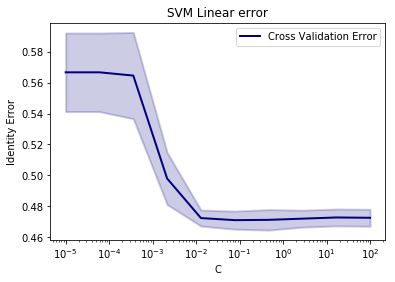

In [26]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_lin_SVM_multi,train_x,train_y, "SVM Linear error", 'C', np.logspace(-5,2,10))
plt.show()

In [36]:
def sk_sig_SVM(C=1.0,gamma=0.0):
    svm = SVC(kernel="sigmoid",C=C,gamma=gamma)
    return svm

def sk_sig_SVM_multi(train_x,train_y,test_x,test_y,C=2.0,gamma=0.1):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_sig_SVM(C=C,gamma=gamma) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        i += 1
    #predict y
    pred_y_raw = [(model.predict(test_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    pred_y_raw = np.array([np.append([1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(11-higher)]) for j in range(len(pred_y_raw))])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    print("(sk) SVM level Accuracy: ",(1-identity_loss(test_y,pred_y)))
    return identity_loss(test_y,pred_y)

(sk) SVM level Accuracy:  0.4945181765724178
(sk) SVM level Accuracy:  0.476905311778291
(sk) SVM level Accuracy:  0.4757505773672055
[0.5054818234275822, 0.523094688221709, 0.5242494226327945]
(sk) SVM level Accuracy:  0.5072129255626082
(sk) SVM level Accuracy:  0.49595842956120095
(sk) SVM level Accuracy:  0.4896073903002309
[0.4927870744373918, 0.504041570438799, 0.5103926096997691]
(sk) SVM level Accuracy:  0.5227928447778418
(sk) SVM level Accuracy:  0.50635103926097
(sk) SVM level Accuracy:  0.5005773672055427
[0.4772071552221581, 0.49364896073903003, 0.49942263279445726]
(sk) SVM level Accuracy:  0.5320253894979804
(sk) SVM level Accuracy:  0.5057736720554272
(sk) SVM level Accuracy:  0.504041570438799
[0.4679746105020196, 0.4942263279445728, 0.4959584295612009]
(sk) SVM level Accuracy:  0.5372186959030583
(sk) SVM level Accuracy:  0.5098152424942264
(sk) SVM level Accuracy:  0.5046189376443417
[0.46278130409694174, 0.49018475750577367, 0.4953810623556582]
(sk) SVM level Accura

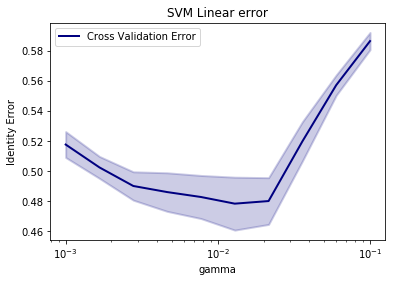

In [37]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_sig_SVM_multi,train_x,train_y, "SVM Linear error", 'gamma', np.logspace(-3,-1,10))
plt.show()

In [251]:
def bin_classify_y(y,val):

    tmp = np.array([[0] for i in range(len(y))])

    for i in range(len(y)):
        if int(y[i][0]) == val:
            tmp[i][0] =  1
        else:
            tmp[i][0] = -1
    return tmp

def bin_predict_y(y,n):
    j = 0
    val = 0
    for i in range(len(y)):
        if y[i]==1:
            val+=i
            j+=1
    if j!=0:
        return int(val/j)
    return 0

In [252]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_rbf_SVM_multi,train_x,train_y, "SVM RBF error", 'C', np.logspace(-2,1,10))
plt.show()

UnboundLocalError: local variable 'pred_y' referenced before assignment

> do for linear, rbf and one other kernel 

> try output classification technique


# Data Analysis

In [ ]:
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

NUM_FEATURE = 12

## Correlation Matrix

In [ ]:
def normalise(data):
    return (data - data.mean())/data.std()

def normalise_all(data):
    for i in range(NUM_FEATURE):
        data[:,i] = normalise(data[:,i])
    return data

In [ ]:
def get_correlation_matrix(data,fig_num):
    data = np.delete(data,-1,axis=1)
    df = pd.DataFrame(data=data)
    fig = plt.figure(fig_num)
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr())
    fig.colorbar(cax)
    return

In [ ]:
def visualise_data(x,y,fig_num):
    sz = np.array([0.2 for x in range(len(y))])
    fig = plt.figure(fig_num)
    for i in range(NUM_FEATURE):
        ax = fig.add_subplot(2,6,i+1)
        x_norm = normalise(x[:,i])
        ax.scatter(x_norm,y,sz)
        ax.set_ylim([0,10])
        ax.set_xlim(xmin=0)

    return

In [ ]:
def get_data_plot(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])
    visualise_data(x,y,fig_num)
    return

In [ ]:
def get_corr_coef(x,y):
    coef_array = np.corrcoef(np.transpose(x),np.transpose(y))
    return coef_array[0,1]


def get_data_output_correlation_plot(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])
    x = normalise_all(x)
    corr = np.array([get_corr_coef(x[:,i],y) for i in range(NUM_FEATURE)])
    x_axis = np.arange(NUM_FEATURE)

    plt.figure(fig_num)
    plt.bar(x_axis,corr)
    return

In [ ]:
def get_output_dist(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])

    fig = plt.figure(fig_num)
    sns.distplot(np.transpose(y))

    return

def get_feature_dist(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])

    x = normalise_all(x)

    fig = plt.figure(fig_num)

    for i in range(NUM_FEATURE):
        ax = fig.add_subplot(2,6,i+1)
        sns.distplot(np.transpose(x[:,i]))

    return

In [ ]:
data = get_data()
get_correlation_matrix(data,1)
get_data_plot(data,2)
get_data_output_correlation_plot(data,3)
get_output_dist(data,4)  
get_feature_dist(data,5)

# TODO
 -  sort out classification problem (one vs all, and decide on boundaries)
 -  explore what C term means
 -  try different SVM kernels
 -  justify SVM choice
 -  equations for everything
 -  justify loss functions
 -  Appendix for Data Analysis
 -  outlier removal (justify with results without it)
 -  gradient descent on parameters (optional)